In [1]:
from pandas.tseries.offsets import BDay
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
import seaborn as sns
import alphalens
import csv

# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/Users/brad_sun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Alphalens Report Generating Step 1: Processing accern signal data...
Alphalens Report Generating Step 1: Finished.
Alphalens Report Generating Step 2: Downloading & Processing yahoo finance price data...
[*********************100%***********************]  490 of 490 downloaded
Alphalens Report Generating Step 2: Finished.
Alphalens Report Generating Step 3: Generating final Alphalens report...
Dropped 22.0% entries from factor data (22.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.2,100.6,25.393062,15.494762,21086,20.614545
2,6.6,138.8,43.067346,22.841553,20215,19.763020
3,9.0,176.4,56.644812,29.704804,20269,19.815812
4,11.4,218.0,69.787455,36.646831,20200,19.748355
5,12.8,292.6,85.743432,45.720958,20517,20.058267


Returns Analysis


,1,2
Ann. alpha,0.066,0.039
beta,-0.004,-0.014
Mean Period Wise Return Top Quantile (bps),4.615,3.033
Mean Period Wise Return Bottom Quantile (bps),-2.733,-1.564
Mean Period Wise Spread (bps),7.272,4.290


Information Analysis


,1,2
IC Mean,0.015,0.013
IC Std.,0.134,0.133
Risk-Adjusted IC,0.111,0.099
t-stat(IC),3.768,3.373
p-value(IC),0.000,0.001
IC Skew,0.050,0.085
IC Kurtosis,0.436,0.333


Turnover Analysis


,1,2
Quantile 1 Mean Turnover,0.728,0.782
Quantile 2 Mean Turnover,0.781,0.813
Quantile 3 Mean Turnover,0.810,0.830
Quantile 4 Mean Turnover,0.793,0.818
Quantile 5 Mean Turnover,0.624,0.686


,1,2
Mean Factor Rank Autocorrelation,0.509,0.416


Alphalens Report Generating Step 3: Finished.


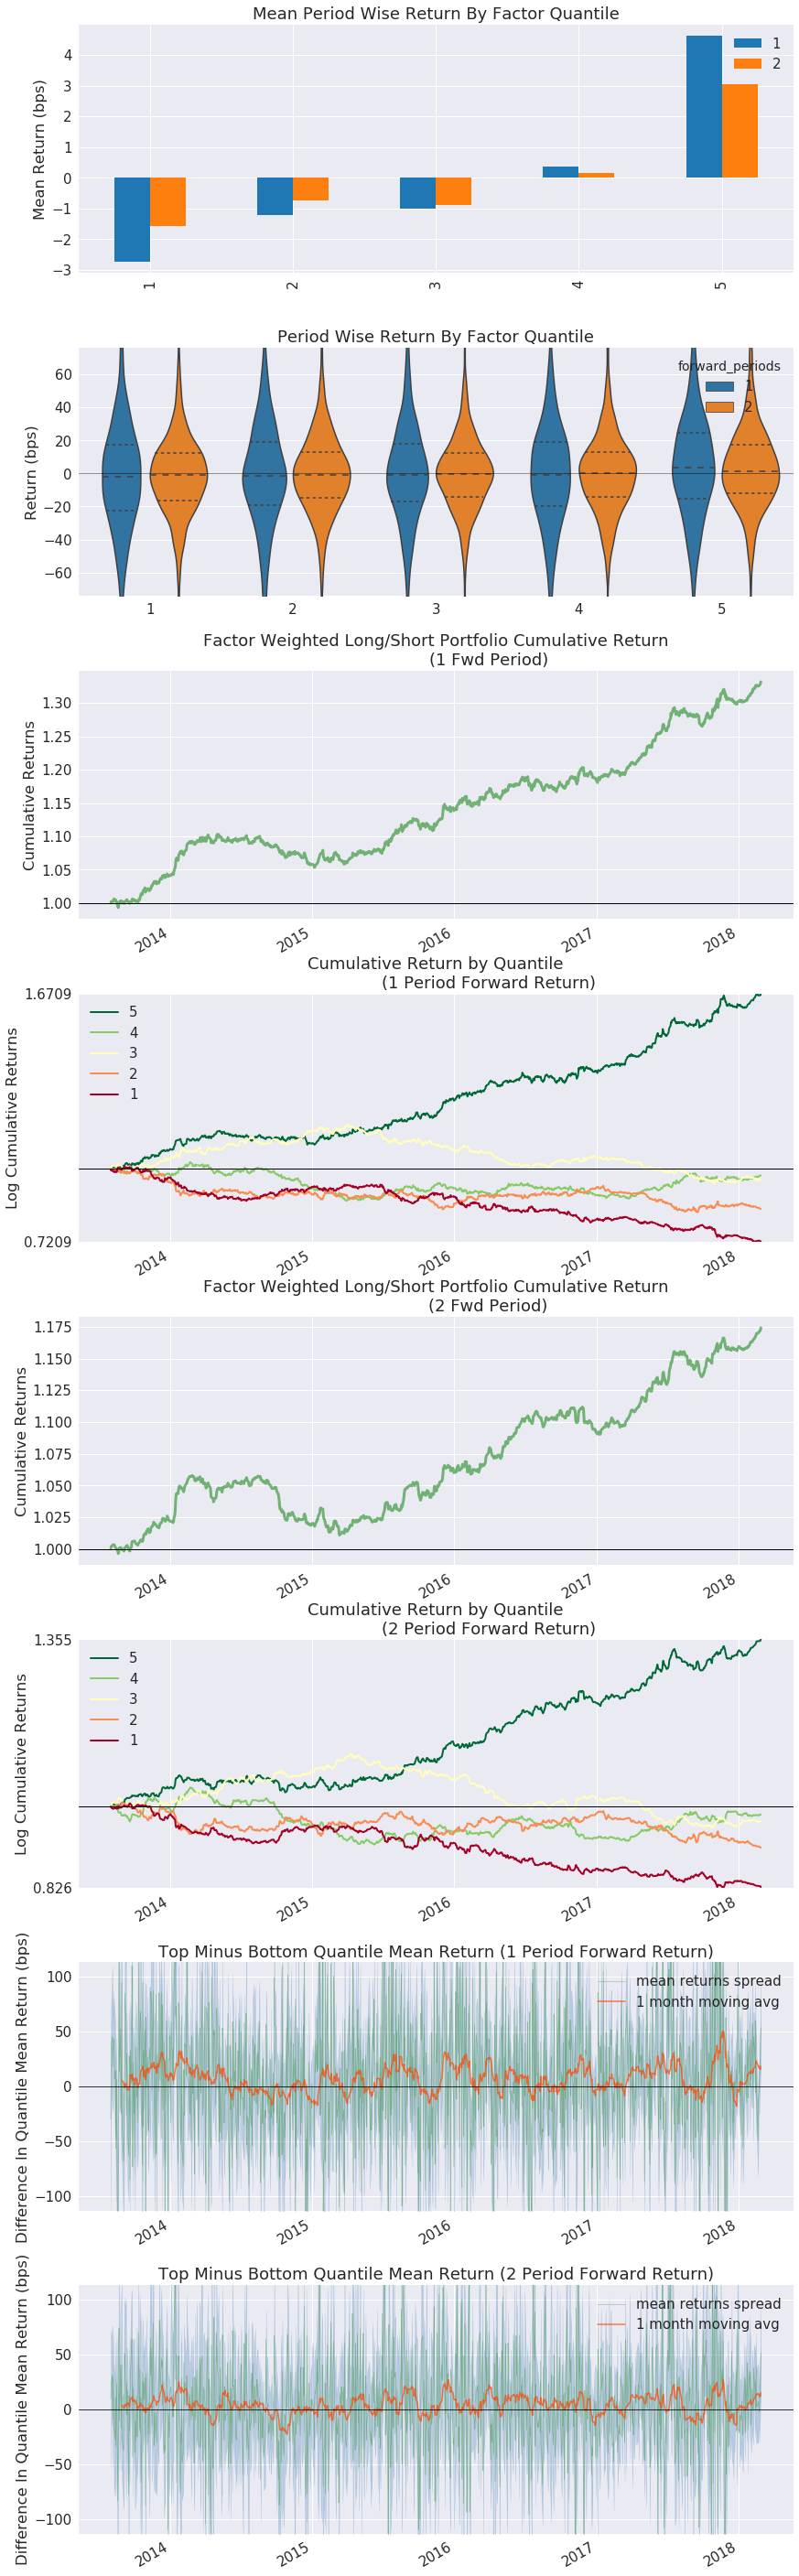

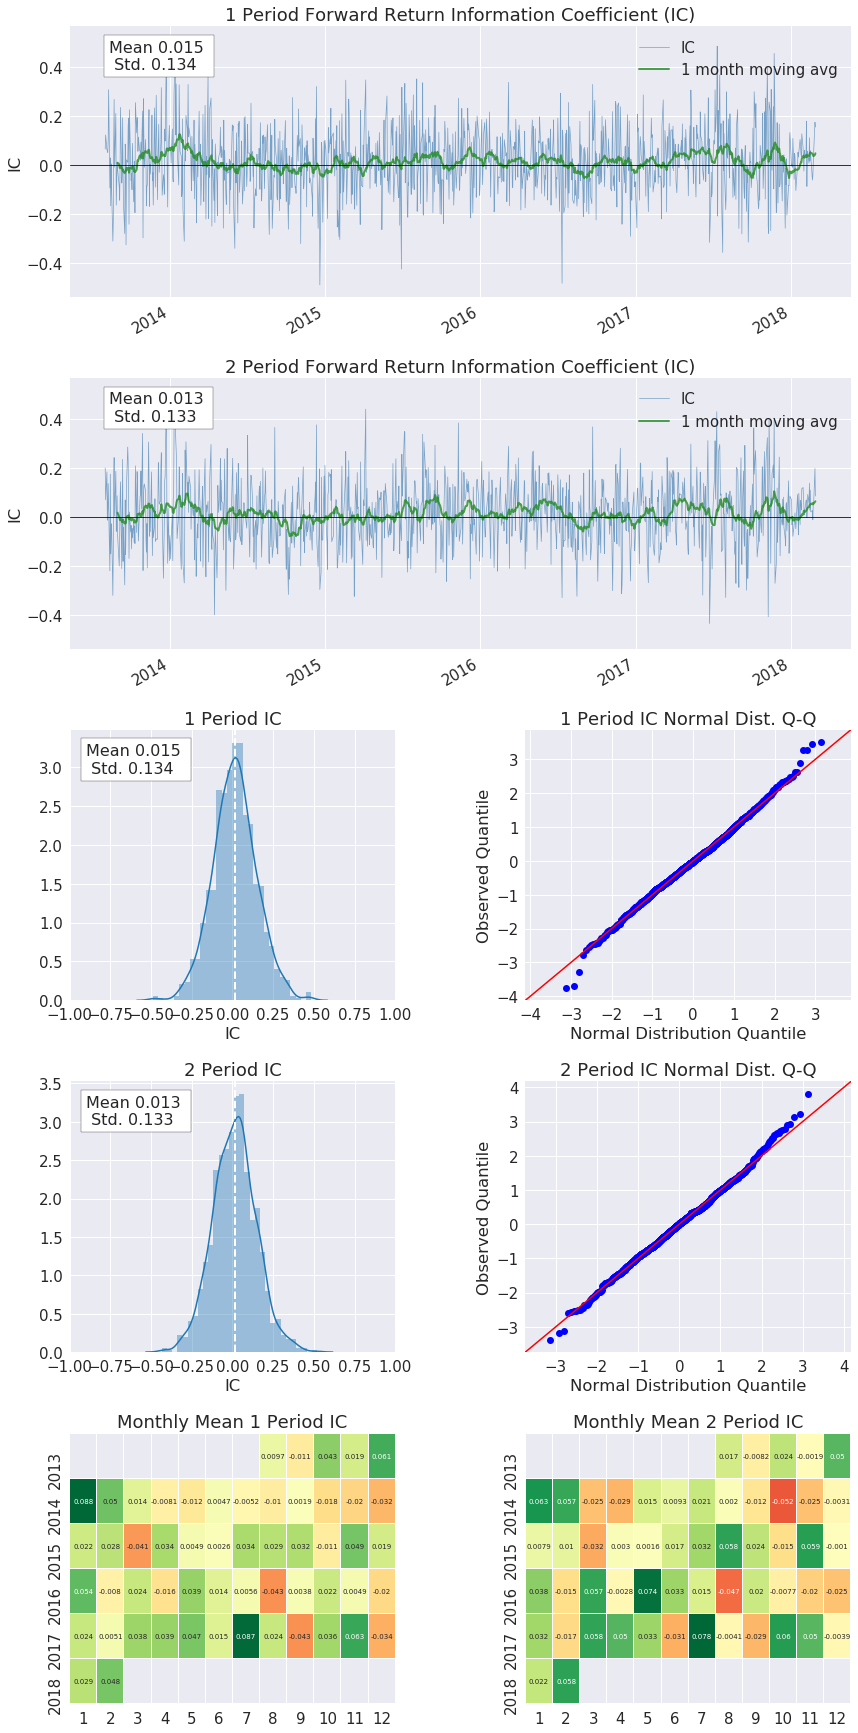

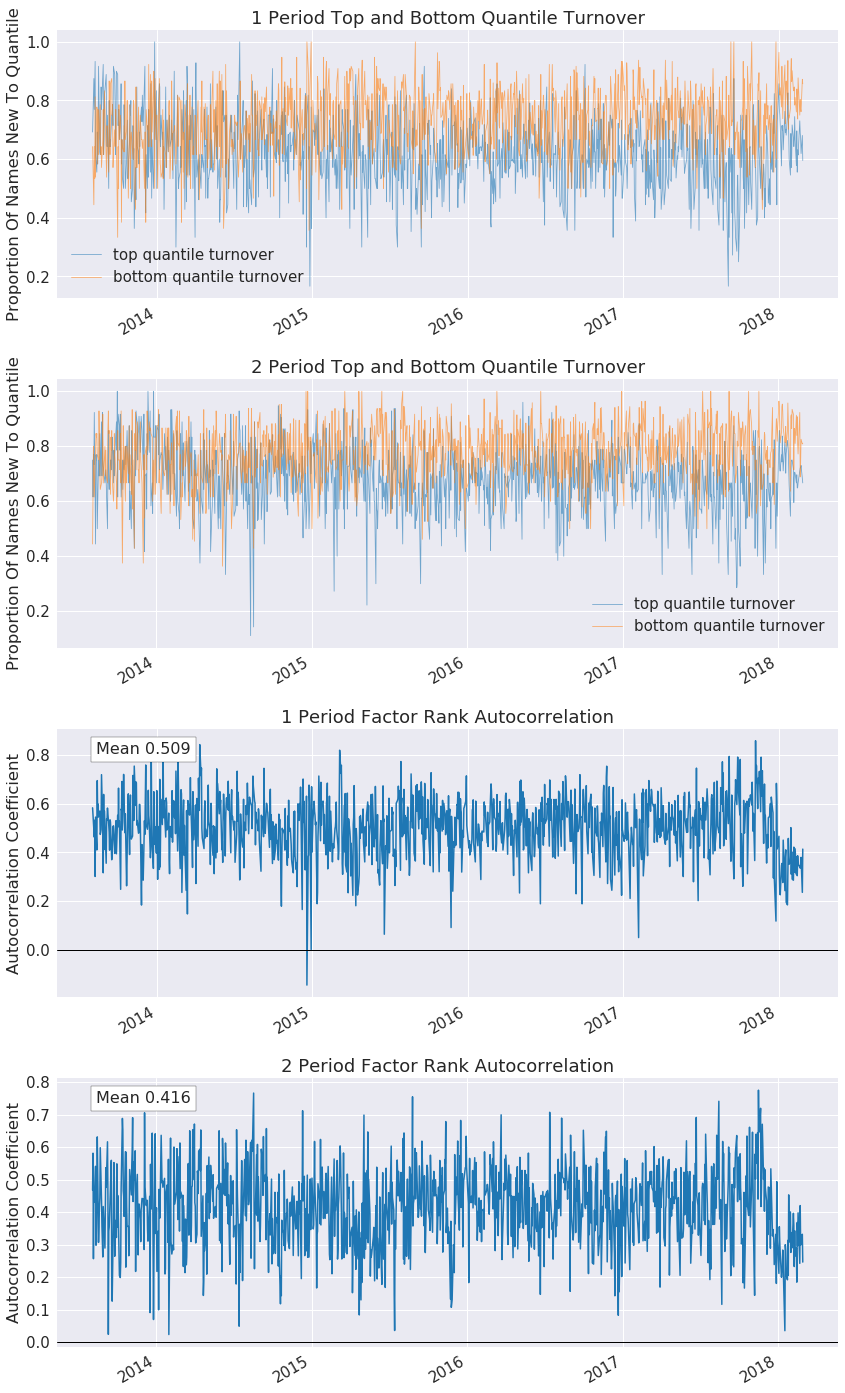

In [2]:
"""
PAT ATTENTION:

Any day shifts should be done in the accern's signal data file before it goes into this alphalens 
result generating pipeline.

"""

# This function helps to convert the raw accern data to the format that alphalens recognizes. 
def convert_accern_df_for_alphalens(df, time_col, ticker_col):
    df['time'] = pd.to_datetime(df[time_col])  
    df = df.sort_values('time')
    factor_index = pd.DatetimeIndex(df['time']).tz_localize('UTC')
    df.set_index([factor_index, df[ticker_col]], inplace=True) 
    del df[time_col]
    del df['time']
    return df


# This function helps to convert the yahoo price data to the format that alphalens recognizes. 
def convert_price_df_for_alphalens(price_df):
    price_df.index = pd.to_datetime(price_df.Date)
    pricing_index = price_df.index.tz_localize('UTC')
    price_df.index = pricing_index
    del price_df['Date']
    return price_df


# Use yahoo package to download data only related to tickers covered in the accern signal file
def get_yahoo_multiple_tickers(accern_df, ticker_col, start_date, end_date):
    ticker_list = list(accern_df[ticker_col].unique())
    df = yf.download(ticker_list, start = start_date, end = end_date)
    df_unstacked = df.to_frame().unstack()
    return df_unstacked


# Certain price here means whether we want close, open, adj_close or stuff from downloaded yahoo finance data
def get_certain_price_type_data(raw_yf_price, certain_price_col):
    certain_price_df = raw_yf_price[certain_price_col]
    certain_price_df['Date'] = certain_price_df.index
    return certain_price_df
    
# Execute:
if __name__ == '__main__':
    # Set up the variables:
    data_path = '/Users/brad_sun/Downloads/accern/accern_data/'
    file_path = '3_22_multi_data_3_dst_story_type_news_ent_rel_lt_70_no_web_filters_count_lt_10.csv'
    score_col = 'alphatrend_dst_score'
    ticker_col = 'entity_ticker'
    certain_price_col = 'Adj Close'
    time_col = 'date'
    start_date = '2013-08-01'
    end_date = '2018-03-01'
    quantiles = 5
    periods = (1, 2)

    
# Step 1:
    print ('='*60)
    print ('Alphalens Report Generating Step 1: Processing accern signal data...')
    # Load accern's signal data file
    accern_file = pd.read_csv(data_path+file_path)
    # Process accern's signal data file to convert to alphalens format
    accern_df = convert_accern_df_for_alphalens(accern_file, time_col, ticker_col)
    print ('Alphalens Report Generating Step 1: Finished.')
    
    
# Step 2:
    print ('='*60)
    print ('Alphalens Report Generating Step 2: Downloading & Processing yahoo finance price data...')
    # Use yahoo package to download data only related to tickers covered in the accern signal file
    price_sp500_yf = get_yahoo_multiple_tickers(accern_file, ticker_col, start_date, end_date)
    # Certain price here means whether we want close, open, adj_close or stuff from downloaded yahoo finance data
    certain_price = get_certain_price_type_data(price_sp500_yf, certain_price_col)
    # Process selected yahoo finance selected price dataset to convert to alphalens format 
    price_df = convert_price_df_for_alphalens(certain_price)
    print ('Alphalens Report Generating Step 2: Finished.')
    
    
# Step 3:
    print ('='*60)
    print ('Alphalens Report Generating Step 3: Generating final Alphalens report...')
    # Use two processed datadframes, i.e. accern_df and price_df to generate alphalens results. 
    factor_df = alphalens.utils.get_clean_factor_and_forward_returns(accern_df[score_col],
                                                                price_df,
                                                                quantiles=quantiles,
                                                                periods=periods,
                                                                max_loss = 1.0)
    print ('='*60)
    alphalens.tears.create_full_tear_sheet(factor_df, by_group=False)
    print ('Alphalens Report Generating Step 3: Finished.')